# Time Series Classification with sktime

The Time Series Classification (TSC) task involves training a model from a collection of time series (real valued, ordered, data) in order to predict a target variable. For example, we might want to build a model that can predict whether a patient is sick based on the ECG reading, or predict whether a device will fail based on some sensor reading. This notebook gives a quick guide to get you started.

<img src="./img/tsc.png" width="600" alt="time series classification"> [<i>&#x200B;</i>](./img/tsc.png)

## Datasets and Problem Types

The UCR/UEA [TSC dataset archive](https://timeseriesclassification.com/) contains a large number of example TSC problems that have been used thousands of times in the literature to assess TSC algorithms. These datasets have certain characteristics that influence what data structure we use to store them in memory.

Most datasets in the archive contain time series all the same length. For example, the [ArrowHead dataset](https://timeseriesclassification.com/description.php?Dataset=ArrowHead) consists of outlines of the images of arrow heads. The classification of projectile points is an important topic in anthropology.

<img src="./img/arrow-heads.png" width="600" alt="arrow heads">

The shapes of the projectile points are converted into a sequence using the angle-based method as described in this [blog post](https://izbicki.me/blog/converting-images-into-time-series-for-data-mining.html) about converting images into time series for data mining.

<img src="./img/from-shapes-to-time-series.png" width="600" alt="from shapes to time series">

Each instance consists of a single time series (i.e. the problem is univariate) of equal length and a class label based on shape distinctions such as the presence and location of a notch in the arrow. The data set consists of 210 instances, by default split into 36 train and 175 test instances. We refer to the collection of time series as $X$ and to the collection of class labels as $y$.

Below, we store the data in a 3D dimensional (instance, variable, time point) numpy array for $X$, and a one dimensional (instance) numpy array for $y$. In TSC the variable portion is commonly referred to as the dimension of the time series instance.

For the single problem loader load arrow head, set the return type to `numpy3D` to store $X$ in such a 3D ndarray. The data can also be returned in other formats, e.g., `pd-multiindex` (row-index hierarchical pandas), or `numpyflat` (2D numpy with rows=instances, columns=time points; alias is `numpy2d`). The full range of options are the `Panel` data format strings desribed in tutorial AA - datatypes and data loaders (see there).

In [1]:
# Plotting and data loading imports used in this notebook
import matplotlib.pyplot as plt

from sktime.datasets import (
    load_arrow_head,
    load_basic_motions,
    load_japanese_vowels,
    load_plaid,
)

(36, 1, 251) (36,) (175, 1, 251) (175,)


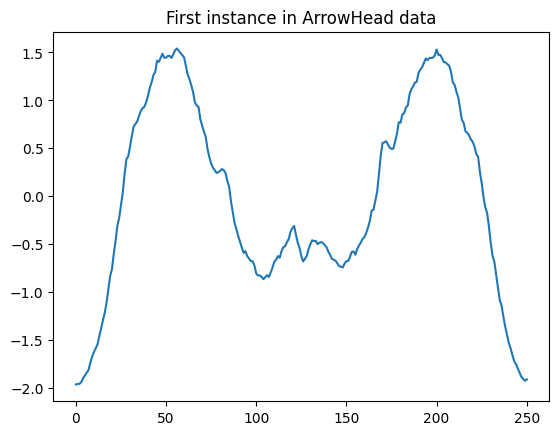

In [2]:
# Load all arrow head
arrow_X, arrow_y = load_arrow_head(return_type="numpy3d")
# Load default train/test splits from sktime/datasets/data
arrow_train_X, arrow_train_y = load_arrow_head(split="train", return_type="numpy3d")
arrow_test_X, arrow_test_y = load_arrow_head(split="test", return_type="numpy3d")
print(arrow_train_X.shape, arrow_train_y.shape, arrow_test_X.shape, arrow_test_y.shape)
plt.title("First instance in ArrowHead data")
plt.plot(arrow_train_X[0, 0])

In [3]:
# Load arrow head dataset, pandas multiindex format, also accepted by sktime classifiers
arrow_train_X, arrow_train_y = load_arrow_head(
    split="train", return_type="pd-multiindex"
)
arrow_test_X, arrow_test_y = load_arrow_head(split="test", return_type="pd-multiindex")
print(arrow_train_X.head())
print(arrow_train_y)

                         dim_0
instances timepoints          
0         0          -1.963009
          1          -1.957825
          2          -1.956145
          3          -1.938289
          4          -1.896657
['0' '1' '2' '0' '1' '2' '0' '1' '2' '0' '1' '2' '0' '1' '2' '0' '1' '2'
 '0' '1' '2' '0' '1' '2' '0' '1' '2' '0' '1' '2' '0' '1' '2' '0' '1' '2']


In [4]:
# Load arrow head dataset in nested pandas format, also accepted by sktime classifiers
arrow_train_X, arrow_train_y = load_arrow_head(split="train", return_type="nested_univ")
arrow_test_X, arrow_test_y = load_arrow_head(split="test", return_type="nested_univ")
print(arrow_train_y)
arrow_train_X.iloc[:5]

['0' '1' '2' '0' '1' '2' '0' '1' '2' '0' '1' '2' '0' '1' '2' '0' '1' '2'
 '0' '1' '2' '0' '1' '2' '0' '1' '2' '0' '1' '2' '0' '1' '2' '0' '1' '2']


,dim_0
0,0 -1.963009 1 -1.957825 2 -1.95614...
1,0 -1.774571 1 -1.774036 2 -1.77658...
2,0 -1.866021 1 -1.841991 2 -1.83502...
3,0 -2.073758 1 -2.073301 2 -2.04460...
4,0 -1.746255 1 -1.741263 2 -1.72274...


In [5]:
# Load arrow head dataset in numpy2d format, also accepted by sktime classifiers
arrow_train_X, arrow_train_y = load_arrow_head(split="train", return_type="numpy2d")
arrow_test_X, arrow_test_y = load_arrow_head(split="test", return_type="numpy2d")
print(arrow_train_X.shape, arrow_train_y.shape, arrow_test_X.shape, arrow_test_y.shape)

# CAUTION:
# while classifiers will interpret 2D numpy arrays as (instance, timepoint),
#   and as a collection/panel of univariate time series, other sktime estimators
#   can interpret 2D numpy arrays as (timepoint, variable),
#   i.e., a single, multivariate time series
#   WARNING: this is also true for individual transformers, when outside a pipeline
#
# the reason for this ambiguity is ensuring sklearn compatibility
#   in classification, numpy 2D is typically passed as (instance, timepoint) to sklearn
#   in forecasting, numpy 2D is typically passed as (timepoint, variable) to sklearn

(36, 251) (36,) (175, 251) (175,)


Some TSC datasets are multivariate, in that each time series instance has more than one variable. For example, the [BasicMotions dataset](https://timeseriesclassification.com/description.php?Dataset=BasicMotions) was generated as part of a student project where four students performed four activities whilst wearing a smartwatch. The watch collects 3D accelerometer and 3D gyroscope data. Each instance involved a subject performing one of four tasks (walking, resting, running and badminton) for ten seconds. Time series in this data set have 6 variables.

<class 'numpy.ndarray'>
(40, 6, 100) (40,) (40, 6, 100) (40,)


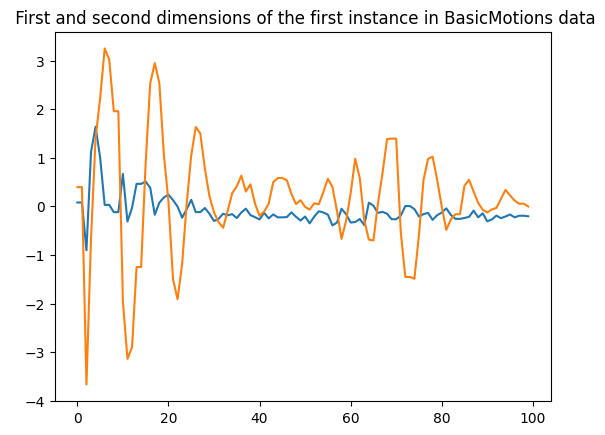

In [6]:
# "basic motions" dataset
motions_X, motions_Y = load_basic_motions(return_type="numpy3d")
motions_train_X, motions_train_y = load_basic_motions(
    split="train", return_type="numpy3d"
)
motions_test_X, motions_test_y = load_basic_motions(split="test", return_type="numpy3d")
print(type(motions_train_X))
print(
    motions_train_X.shape,
    motions_train_y.shape,
    motions_test_X.shape,
    motions_test_y.shape,
)
plt.title(" First and second dimensions of the first instance in BasicMotions data")
plt.plot(motions_train_X[0][0])
plt.plot(motions_train_X[0][1])

Some data sets have unequal length series. Two data sets with this characteristic are shipped with sktime: PLAID (univariate) and JapaneseVowels (multivariate). We cannot store unequal length series in `numpy` arrays. Instead, we use a nested `pandas` `DataFrame`, where each cell is a `pandas` `Series`. This is the default return type for all single problem loaders.

<class 'pandas.core.frame.DataFrame'>


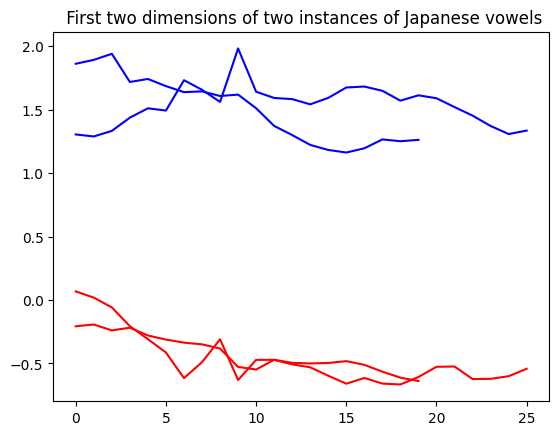

In [7]:
# loads both train and test together
vowel_X, vowel_y = load_japanese_vowels()
print(type(vowel_X))

plt.title(" First two dimensions of two instances of Japanese vowels")
plt.plot(vowel_X.iloc[0, 0], color="b")
plt.plot(vowel_X.iloc[1, 0], color="b")
plt.plot(vowel_X.iloc[0, 1], color="r")
plt.plot(vowel_X.iloc[1, 1], color="r")
plt.show()

<class 'pandas.core.frame.DataFrame'>


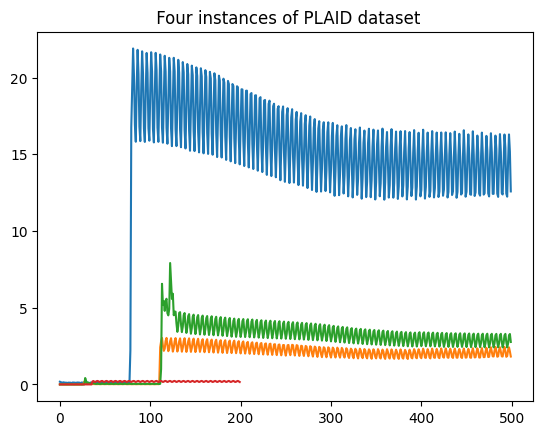

In [8]:
plaid_X, plaid_y = load_plaid()
plaid_train_X, plaid_train_y = load_plaid(split="train")
plaid_test_X, plaid_test_y = load_plaid(split="test")
print(type(plaid_X))

plt.title(" Four instances of PLAID dataset")
plt.plot(plaid_X.iloc[0, 0])
plt.plot(plaid_X.iloc[1, 0])
plt.plot(plaid_X.iloc[2, 0])
plt.plot(plaid_X.iloc[3, 0])
plt.show()

## Building Classifiers

We show the simplest use cases for classifiers and demonstrate how to build bespoke pipelines for time series classification.

It is possible to use a standard `sklearn` classifier for univariate, equal length classification problems, but it is unlikely to perform as well as bespoke time series classifiers, since supervised tabular classifiers ignore the sequence information in the variables.

To apply `sklearn` classifiers directly, the data needs to be reshaped into one of the sklearn compatible 2D data formats. `sklearn` cannot be used directly with multivariate or unequal length data sets, without making choices in how to insert the data into a 2D structure.

`sktime` provides functionality to make these choices explicit and tunable, under a unified interface for time series classifiers.

`sktime` also provides pipeline construction functionality for transformers and classifiers that are specific to time series datasets.

Direct application of `sklearn` (without `sktime`) is possible via using the `numpy2d` return type for the time series data sets, and then feeding the format into `sklearn`:

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

classifier = RandomForestClassifier(n_estimators=100)
arrow_train_X_2d, arrow_train_y_2d = load_arrow_head(
    split="train", return_type="numpy2d"
)
print(arrow_train_X_2d.shape, arrow_train_y_2d.shape)
arrow_test_X_2d, arrow_test_y_2d = load_arrow_head(split="test", return_type="numpy2d")
classifier.fit(arrow_train_X_2d, arrow_train_y_2d)
y_pred = classifier.predict(arrow_test_X_2d)

accuracy_score(arrow_test_y_2d, y_pred)

(36, 251) (36,)


0.6742857142857143

`sktime` contains the state of the art in time series classifiers in the package classification. These are grouped based on their representation. An accurate and relatively fast classifier is the [ROCKET](https://link.springer.com/article/10.1007/s10618-020-00701-z) algorithm:

In [10]:
from sktime.classification.kernel_based import RocketClassifier

rocket = RocketClassifier(num_kernels=2000)
rocket.fit(arrow_train_X, arrow_train_y)
y_pred = rocket.predict(arrow_test_X)

accuracy_score(arrow_test_y, y_pred)

0.8228571428571428

Another accurate classifier for time series classification is version 2 of the [HIVE-COTE](https://link.springer.com/article/10.1007/s10994-021-06057-9) algorithm. HC2 is slow on small problems like these examples. However, it can be configured with an approximate maximum run time as follows (may take a bit longer than 12 seconds to run this cell):

In [11]:
from sktime.classification.hybrid import HIVECOTEV2

hc2 = HIVECOTEV2(time_limit_in_minutes=0.2)
hc2.fit(arrow_train_X, arrow_train_y)
y_pred = hc2.predict(arrow_test_X)

accuracy_score(arrow_test_y, y_pred)

0.8628571428571429

## Creating Pipelines

Most classifiers in `sktime` involve some degree of transformation. The simplest form consists of a pipeline of transformation (aka "feature extraction") followed by an `sklearn` classifier.

The `sktime` `make_pipeline` utility allows the combination of transformers and classifiers into a simple pipeline. The classifier pipelined can be an `sktime` time series classifier, or an `sklearn` tabular classifier. If an `sklearn` classifier, the time series are formatted as (instance, time index) formatted 2D array before being passed to the `sklearn` classifier.

In the following example, we use the [Catch22](https://link.springer.com/article/10.1007/s10618-019-00647-x) feature extractor to extract features which are then used in a (tabular, `sklearn`) Random Forest classifier. This can be done with the `sktime`'s `make_pipeline` utility as follows:

In [12]:
from sklearn.ensemble import RandomForestClassifier

from sktime.pipeline import make_pipeline
from sktime.transformations.panel.catch22 import Catch22

catch22 = Catch22()
randf = RandomForestClassifier(n_estimators=100)
pipe = make_pipeline(catch22, randf)

pipe.fit(arrow_train_X, arrow_train_y)
y_pred = pipe.predict(arrow_test_X)

accuracy_score(arrow_test_y, y_pred)

/home/tomxu/sktime/sktime/datatypes/_panel/_convert.py:713: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for _label, _series in multi_ind_dataframe.iteritems():  # noqa
/home/tomxu/sktime/sktime/datatypes/_panel/_convert.py:713: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for _label, _series in multi_ind_dataframe.iteritems():  # noqa


0.6971428571428572

Other transformations such as the `TSFreshFeatureExtractor` for the [tsfresh](https://www.sciencedirect.com/science/article/pii/S0925231218304843) feature set, `SummaryTransformer` for basic summary statistics, and the `RandomShapeletTransform` for the [shapelet transform](https://link.springer.com/chapter/10.1007/978-3-662-55608-5_2) can also be used in pipelines following the same creation and fit/predict structure.

In the following example, we pipeline an `sktime` transformer with an `sktime` time series classifier using the `*` dunder operator, which is a shorthand for `make_pipeline`. Estimators on the right are pipelined after estimators on the left of the operator:

In [13]:
from sktime.classification.kernel_based import RocketClassifier
from sktime.transformations.series.exponent import ExponentTransformer

square = ExponentTransformer(power=2)
rocket = RocketClassifier(num_kernels=2000)
pipe_sktime = square * rocket

pipe_sktime.fit(arrow_train_X, arrow_train_y)
y_pred = pipe_sktime.predict(arrow_test_X)

accuracy_score(arrow_test_y, y_pred)

0.8057142857142857

Under the hood, `sktime`'s `make_pipeline` utility dispatches to right pipeline class that exposes different kinds of pipeline under the familiar `sktime` time series classification interface. In the above examples, these were `SklearnClassifierPipeline` (for `sklearn` classifiers at the end) and `ClassifierPipeline` (for `sktime` classifiers at the end):

In [14]:
pipe

SklearnClassifierPipeline(classifier=RandomForestClassifier(),
                          transformers=[Catch22()])

In [15]:
pipe_sktime

ClassifierPipeline(classifier=RocketClassifier(num_kernels=2000),
                   transformers=[ExponentTransformer(power=2)])

Alternatively, the pipelines could have been constructed directly with the special pipeline classes for more granular control, see docstrings of the aforementioned classes for further options.

Using `sktime` pipeline constructs is encouraged above using `sklearn` `Pipeline`, as `sktime` pipelines will come with base class features such as input checks, input data format compatibility, and tag handling. However, `sktime` estimators are, in general, also compatible with `sklearn` pipelining use cases, as long as the `sklearn` adjacent data formats are being used, namely `numpy3D` or `nested_univ`. Conversely, `sklearn` native compositor elements will in general not be compatible with use of row hierarchical data formats such as `pd-multiindex`, and will not automatically convert, or provide `sktime` compatible tag inspection functionality.

## sklearn Compatability

`sktime` classifiers are compatible with `sklearn` model selection and composition tools using `sktime` data formats. We provide some functionality examples in the following.

Cross-validation using the `sklearn` `cross_val_score` and `KFold` functionality:

In [16]:
from sklearn.model_selection import KFold, cross_val_score

cross_val_score(rocket, arrow_train_X, y=arrow_train_y, cv=KFold(n_splits=4))

array([0.88888889, 0.77777778, 0.88888889, 0.77777778])

Parameter tuning using `sklearn` `GridSearchCV`, we tune the _k_ and distance measure for a K-NN classifier:

In [17]:
from sklearn.model_selection import GridSearchCV

from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier()
param_grid = {"n_neighbors": [1, 5], "distance": ["euclidean", "dtw"]}
parameter_tuning_method = GridSearchCV(knn, param_grid, cv=KFold(n_splits=4))

parameter_tuning_method.fit(arrow_train_X, arrow_train_y)
y_pred = parameter_tuning_method.predict(arrow_test_X)

accuracy_score(arrow_test_y, y_pred)

0.8

Probability calibration with the `sklearn` `CalibratedClassifierCV`:

In [18]:
from sklearn.calibration import CalibratedClassifierCV

from sktime.classification.interval_based import DrCIF

calibrated_drcif = CalibratedClassifierCV(
    estimator=DrCIF(n_estimators=10, n_intervals=5), cv=4
)

calibrated_drcif.fit(arrow_train_X, arrow_train_y)
y_pred = calibrated_drcif.predict(arrow_test_X)

accuracy_score(arrow_test_y, y_pred)

0.7771428571428571

## Multivariate Classification

Many classifiers, including ROCKET and HC2, are configured to work with multivariate input. For example:

In [19]:
from sktime.classification.kernel_based import RocketClassifier

rocket = RocketClassifier(num_kernels=2000)
rocket.fit(motions_train_X, motions_train_y)
y_pred = rocket.predict(motions_test_X)

accuracy_score(motions_test_y, y_pred)

1.0

In [20]:
from sktime.classification.hybrid import HIVECOTEV2

HIVECOTEV2(time_limit_in_minutes=0.2)
hc2.fit(motions_train_X, motions_train_y)
y_pred = hc2.predict(motions_test_X)

accuracy_score(motions_test_y, y_pred)

1.0

`sktime` offers two other ways of building estimators for multivariate time series problems:

1. Concatenation of time series columns into a single long time series column via `ColumnConcatenator` and apply a classifier to the concatenated data,
2. Dimension ensembling via `ColumnEnsembleClassifier` in which one classifier is fitted for each time series column/dimension of the time series and their predictions are combined through a voting scheme. 

We can concatenate multivariate time series/panel data into long univariate time series/panel using a transform and then apply a classifier to the univariate data:

In [21]:
from sktime.classification.interval_based import DrCIF
from sktime.transformations.panel.compose import ColumnConcatenator

clf = ColumnConcatenator() * DrCIF(n_estimators=10, n_intervals=5)
clf.fit(motions_train_X, motions_train_y)
y_pred = clf.predict(motions_test_X)

accuracy_score(motions_test_y, y_pred)

1.0

We can also fit one classifier for each time series column and then aggregate their predictions. The interface is similar to the familiar `ColumnTransformer` from `sklearn`.

In [22]:
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.interval_based import DrCIF
from sktime.classification.kernel_based import RocketClassifier

col = ColumnEnsembleClassifier(
    estimators=[
        ("DrCIF0", DrCIF(n_estimators=10, n_intervals=5), [0]),
        ("ROCKET3", RocketClassifier(num_kernels=1000), [3]),
    ]
)

col.fit(motions_train_X, motions_train_y)
y_pred = col.predict(motions_test_X)

accuracy_score(motions_test_y, y_pred)

0.9

## Classification with Unequal Length Series

A common trait in time series data is absence of a uniform series length, as seen in the PLAID and JapaneseVowels datasets introduced previously. None of the `numpy` data formats support ragged arrays, as such one of the `pandas` `DataFrame` formats must be used for unequal length data.

At the time of writing the number of classifiers which natively support unequal length series is limited. The following outputs the current classifiers which support unequal length data.

In [23]:
from sktime.registry import all_estimators

# search for all classifiers which can handle unequal length data. This may give some
# UserWarnings if soft dependencies are not installed.
all_estimators(
    filter_tags={"capability:unequal_length": True}, estimator_types="classifier"
)

2022-12-29 19:35:37.124664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 19:35:37.952337: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-29 19:35:37.952448: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-29 19:35:37.952457: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

[('DummyClassifier', sktime.classification.dummy._dummy.DummyClassifier),
 ('KNeighborsTimeSeriesClassifier',
  sktime.classification.distance_based._time_series_neighbors.KNeighborsTimeSeriesClassifier)]

In [29]:
# most popoular early classifier is TEASER
all_estimators(
    estimator_types="early_classifier"
) 

[('TEASER', sktime.classification.early_classification._teaser.TEASER)]

Certain `sktime` transformers such as the `PaddingTransformer` and `TruncationTransformer` can be used in a pipeline to process unequal length data for use in a wider range of classification algorithms. Transformers which equalise the length of seres can be found using the `"capability:unequal_length:removes"` tag.


In [8]:
from sktime.classification.feature_based import RandomIntervalClassifier
from sktime.transformations.panel.padder import PaddingTransformer

padded_clf = PaddingTransformer() * RandomIntervalClassifier(n_intervals=5)
padded_clf.fit(plaid_train_X, plaid_test_y)
y_pred = padded_clf.predict(plaid_test_X)

accuracy_score(plaid_test_y, y_pred)

/home/tomxu/sktime/sktime/datatypes/_panel/_convert.py:713: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for _label, _series in multi_ind_dataframe.iteritems():  # noqa
/home/tomxu/sktime/sktime/datatypes/_panel/_convert.py:713: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for _label, _series in multi_ind_dataframe.iteritems():  # noqa
/home/tomxu/sktime/sktime/datatypes/_panel/_convert.py:713: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for _label, _series in multi_ind_dataframe.iteritems():  # noqa
/home/tomxu/sktime/sktime/datatypes/_panel/_convert.py:713: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for _label, _series in multi_ind_dataframe.iteritems():  # noqa


0.5121042830540037

### Background info and references for classifiers used here

#### KNeighborsTimeSeriesClassifier

One nearest neighbour (1-NN) classification with Dynamic Time Warping (DTW) is one of the oldest TSC approaches, and is commonly used as a performance benchmark.

#### RocketClassifier
The RocketClassifier is based on a pipeline combination of the ROCKET transformation (transformations.panel.rocket) and the sklearn RidgeClassifierCV classifier. The RocketClassifier is configurable to use variants MiniRocket and MultiRocket. ROCKET is based on generating random convolutional kernels. A large number are generated, then a linear classifier is built on the output.

[1] Dempster, Angus, François Petitjean, and Geoffrey I. Webb. "Rocket: exceptionally fast and accurate time series classification using random convolutional kernels." Data Mining and Knowledge Discovery (2020)
[arXiv version](https://arxiv.org/abs/1910.13051)
[DAMI 2020](https://link.springer.com/article/10.1007/s10618-020-00701-z)

#### DrCIF
The Diverse Representation Canonical Interval Forest Classifier (DrCIF) is an interval based classifier. The algorithm takes multiple randomised intervals from each series and extracts a range of features. These features are used to build a decision tree, which in turn are ensembled into a decision tree forest, in the style of a random forest.

Original CIF classifier:
[2] Matthew Middlehurst and James Large and Anthony Bagnall. "The Canonical Interval Forest (CIF) Classifier for Time Series Classification." IEEE International Conference on Big Data (2020)
[arXiv version](https://arxiv.org/abs/2008.09172)
[IEEE BigData (2020)](https://ieeexplore.ieee.org/abstract/document/9378424?casa_token=8g_IG5MLJZ4AAAAA:ItxW0bY4eCRwfdV9kLvf-8a8X73UFCYUGU9D19PwrHigjivLJVchxHwkM3Btn7vvlOJ_0HiLRa3LCA)

The DrCIF adjustment was proposed in [3].

#### HIVE-COTE 2.0 (HC2)
The HIerarchical VotE Collective of Transformation-based Ensembles is a meta ensemble that combines classifiers built on different representations. Version 2  combines DrCIF, TDE, an ensemble of RocketClassifiers called the Arsenal and the  ShapeletTransformClassifier. It is one of the most accurate classifiers on the UCR and UEA time series archives.
   
[3] Middlehurst, Matthew, James Large, Michael Flynn, Jason Lines, Aaron Bostrom, and Anthony Bagnall. "HIVE-COTE 2.0: a new meta ensemble for time series classification." Machine Learning (2021)
[ML 2021](https://link.springer.com/article/10.1007/s10994-021-06057-9)

#### Catch22

The CAnonical Time-series CHaracteristics (Catch22) are a set of 22 informative and low redundancy features extracted from time series data. The features were filtered from 4791 features in the `hctsa` toolkit.

[4] Lubba, Carl H., Sarab S. Sethi, Philip Knaute, Simon R. Schultz, Ben D. Fulcher, and Nick S. Jones. "catch22: Canonical time-series characteristics." Data Mining and Knowledge Discovery (2019)
[DAMI 2019](https://link.springer.com/article/10.1007/s10618-019-00647-x)